
#  the model in this file comes from this website

#  https://geertlitjens.nl/post/getting-started-with-camelyon/



#  without editing the model, it is 80% accurate/confident

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds

pcam, pcam_info = tfds.load("patch_camelyon", data_dir='/content/drive/My Drive/Colab Notebooks',download=False, with_info=True) 

In [0]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [0]:
#print(pcam)

In [0]:
#First setup the input to the network which has the dimensions of the patches contained within PatchCAMELYON
input_img = Input(shape=(96,96,3))

# Now we define the layers of the convolutional network: three blocks of two convolutional layers and a max-pool layer.
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Now we flatten the output from a 4D to a 2D tensor to be able to use fully-connected (dense) layers for the final
# classification part. Here we also use a bit of dropout for regularization. The last layer uses a softmax to obtain class
# likelihoods (i.e. metastasis vs. non-metastasis)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
predictions = Dense(2, activation='softmax')(x)

# Now we define the inputs/outputs of the model and setup the optimizer. In this case we use regular stochastic gradient
# descent with Nesterov momentum. The loss we use is cross-entropy and we would like to output accuracy as an additional metric.
model = Model(inputs=input_img, outputs=predictions)
sgd_opt = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=True)
model.compile(optimizer=sgd_opt,#Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 94, 94, 16)        448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 92, 92, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 44, 44, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 32)        0   

In [0]:
import random

def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.rot90(image, random.randint(0,3))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [0]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint_cb = ModelCheckpoint("/content/drive/My Drive/geert_preprocessing_model_SGD.h5", 
                                      monitor='val_loss', mode='min', verbose=2, save_best_only=True)
callbacks_list = [early_stopping_cb, model_checkpoint_cb]

In [0]:
hist = model.fit(train_pipeline,
                 validation_data=valid_pipeline, callbacks=callbacks_list,
                 verbose=2, epochs=30, steps_per_epoch=4096, validation_steps=256)

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.43708, saving model to /content/drive/My Drive/geert_preprocessing_model_SGD.h5
4096/4096 - 210s - loss: 0.5039 - accuracy: 0.7536 - val_loss: 0.4371 - val_accuracy: 0.7963
Epoch 2/30

Epoch 00002: val_loss improved from 0.43708 to 0.42093, saving model to /content/drive/My Drive/geert_preprocessing_model_SGD.h5
4096/4096 - 209s - loss: 0.4028 - accuracy: 0.8219 - val_loss: 0.4209 - val_accuracy: 0.8008
Epoch 3/30

Epoch 00003: val_loss improved from 0.42093 to 0.40577, saving model to /content/drive/My Drive/geert_preprocessing_model_SGD.h5
4096/4096 - 194s - loss: 0.3665 - accuracy: 0.8415 - val_loss: 0.4058 - val_accuracy: 0.8094
Epoch 4/30

Epoch 00004: val_loss improved from 0.40577 to 0.38746, saving model to /content/drive/My Drive/geert_preprocessing_model_SGD.h5
4096/4096 - 201s - loss: 0.3393 - accuracy: 0.8559 - val_loss: 0.3875 - val_accuracy: 0.8177
Epoch 5/30

Epoch 00005: val_loss did not improve from 0.38746
4096/

In [0]:
best_model = load_model("/content/drive/My Drive/geert_preprocessing_model_SGD.h5")
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(best_model.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Test set accuracy is 0.8470


In [0]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(697)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


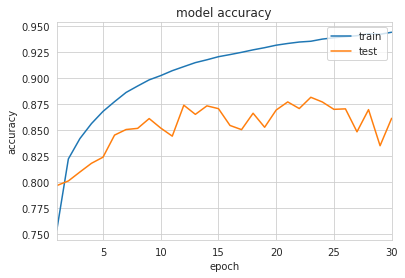

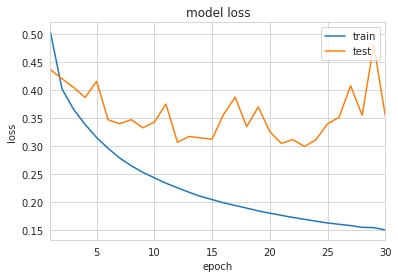

In [0]:
dim = np.arange(1, len(hist.history['accuracy']) + 1)
plt.figure()
plt.xlim(1, len(hist.history['accuracy']))
plt.plot(dim, hist.history['accuracy'])
plt.plot(dim, hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for loss
plt.figure()
plt.xlim(1, len(hist.history['accuracy']))
plt.plot(dim, hist.history['loss'])
plt.plot(dim, hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
# Code below from https://www.kaggle.com/georsara1/95-auc-score-in-train-sample-with-neural-nets

#Predict on test set
predictions_NN_prob = best_model.predict(test_pipeline)
predictions_NN_prob = predictions_NN_prob[:,1]

predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

y_numpy = pcam['test'].as_numpy_iterator()
test_y = np.array([i['label'] for i in y_numpy])

#Print accuracy
acc_NN = accuracy_score(test_y, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN)

Overall accuracy of Neural Network model: 0.845123291015625


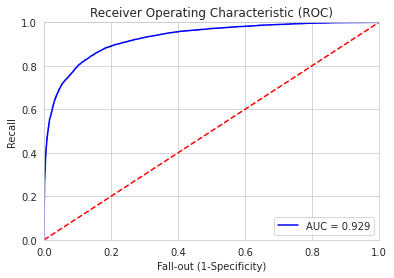

In [0]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

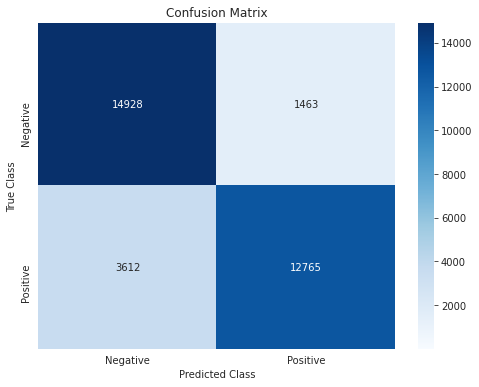

In [0]:
#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()